In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline

import sys
sys.path.append("..") 
from tp_utils.data_provider import read_prices, read_data

In [3]:
market = 'BNB-BTC'
market = 'BTC-USDT'
tf = '15m'

df_raw = read_data(market, tf)
assert df_raw[df_raw.isna()==True].sum().sum() == 0

In [4]:
df = df_raw[-10000:]

In [5]:
def log_returns(price):

    return np.diff(np.log(price))

In [6]:
rets = log_returns(df['C'])

In [7]:
from pandas import read_csv
from statsmodels.tsa.stattools import adfuller

X = rets
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -26.196446
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


## ESN

In [7]:
from pyESN import ESN 

n_reservoir= 500
sparsity=0.2
rand_seed=23
spectral_radius = 1.2
noise = .0005


esn = ESN(n_inputs = 1,
      n_outputs = 1, 
      n_reservoir = n_reservoir,
      sparsity=sparsity,
      random_state=rand_seed,
      spectral_radius = spectral_radius,
      noise=noise)

In [8]:
data = rets

In [56]:
%%time
trainlen = 100
future = 1
futureTotal=100
pred_tot=np.zeros(futureTotal)

for i in range(0,futureTotal,future):
    pred_training = esn.fit(np.ones(trainlen),data[i:trainlen+i])
    prediction = esn.predict(np.ones(future))
    pred_tot[i:i+future] = prediction[:,0]

Wall time: 2.95 s


In [57]:
y_true = np.sign(data[trainlen:trainlen+futureTotal])
y_pred = np.sign(pred_tot)
np.mean(y_true == y_pred)

0.44

In [10]:
import seaborn as sns
from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=False)

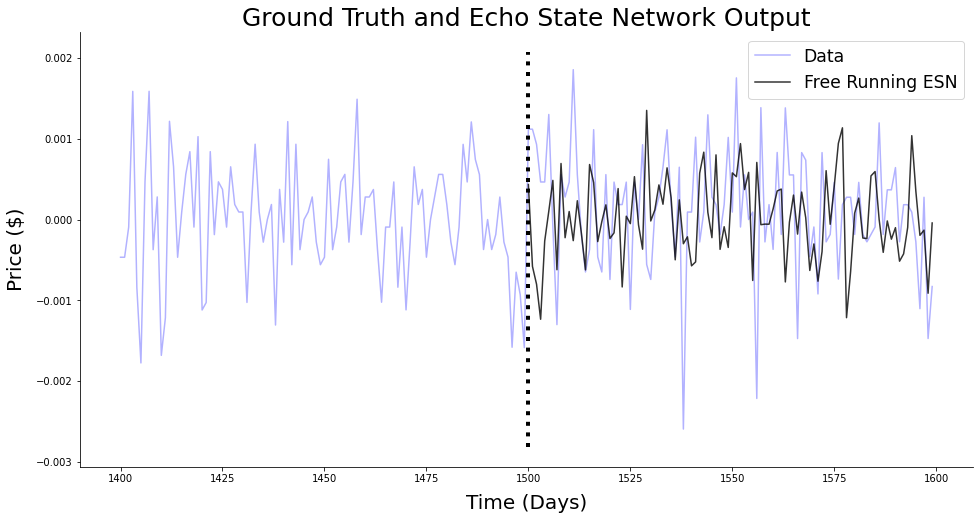

In [13]:
plt.figure(figsize=(16,8))
plt.plot(range(1400,trainlen+futureTotal),data[1400:trainlen+futureTotal],'b',label="Data", alpha=0.3)
#plt.plot(range(0,trainlen),pred_training,'.g',  alpha=0.3)
plt.plot(range(trainlen,trainlen+futureTotal),pred_tot,'k',  alpha=0.8, label='Free Running ESN')

lo,hi = plt.ylim()
plt.plot([trainlen,trainlen],[lo+np.spacing(1),hi-np.spacing(1)],'k:', linewidth=4)

plt.title(r'Ground Truth and Echo State Network Output', fontsize=25)
plt.xlabel(r'Time (Days)', fontsize=20,labelpad=10)
plt.ylabel(r'Price ($)', fontsize=20,labelpad=10)
plt.legend(fontsize='xx-large', loc='best')
sns.despine()


In [58]:
## Tune